In [352]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader,TensorDataset
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from scipy import stats
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

import numpy as np

import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import set_matplotlib_formats
set_matplotlib_formats('svg')
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
import missingno as msno
!pip install rapidfuzz
from rapidfuzz import process

<ipython-input-352-ab2304a01e08>:18: DeprecationWarning: `set_matplotlib_formats` is deprecated since IPython 7.23, directly use `matplotlib_inline.backend_inline.set_matplotlib_formats()`
  set_matplotlib_formats('svg')


In [353]:
file_path ="/content/MTRX10000.csv"

df = pd.read_csv(file_path)

In [354]:
df.info()

# List numeric and categorical features
numeric_cols = df.select_dtypes(include='number').columns
categorical_cols = df.select_dtypes(include='object').columns

print("Numerical Features:\n", numeric_cols)
print("\nCategorical Features:\n", categorical_cols)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9999 entries, 0 to 9998
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   FULL_DATE         9997 non-null   object 
 1   INVOICE_ID        9997 non-null   float64
 2   REPAIRER_NAME     9995 non-null   object 
 3   SERVICE           9997 non-null   object 
 4   ITEM_NAME         9997 non-null   object 
 5   ITEM_AMOUNT       9997 non-null   float64
 6   REPAIRER_CITY     8506 non-null   object 
 7   REPAIRER_STATE    8506 non-null   object 
 8   REPAIRER_COUNTRY  8506 non-null   object 
 9   REPAIRER_ZIP      9370 non-null   object 
 10  VIN               9997 non-null   object 
 11  VEHICLE_YEAR      9989 non-null   float64
 12  VEHICLE_MAKE      9997 non-null   object 
 13  VEHICLE_MODEL     9994 non-null   object 
 14  SUPPLIER_NAME     9997 non-null   object 
 15  SUPPLIER_CITY     5531 non-null   object 
 16  SUPPLIER_STATE    5531 non-null   object 


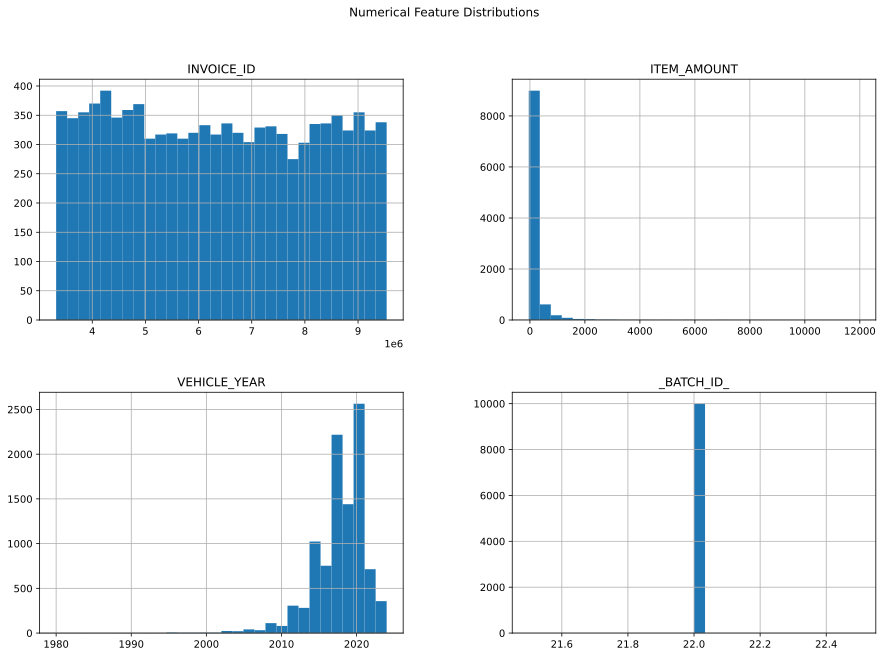

In [355]:
#Histograms for numeric columns
df[numeric_cols].hist(bins=30, figsize=(15, 10))
plt.suptitle("Numerical Feature Distributions")
plt.show()

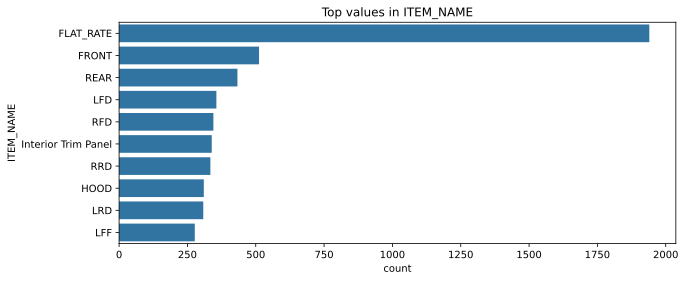

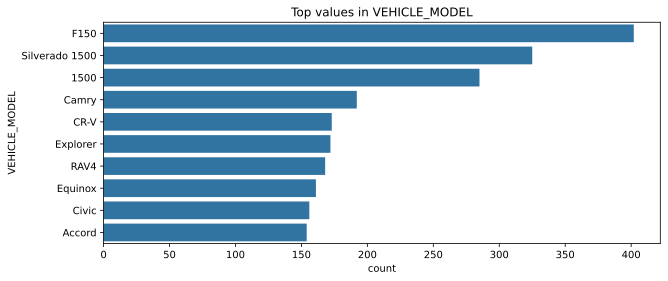

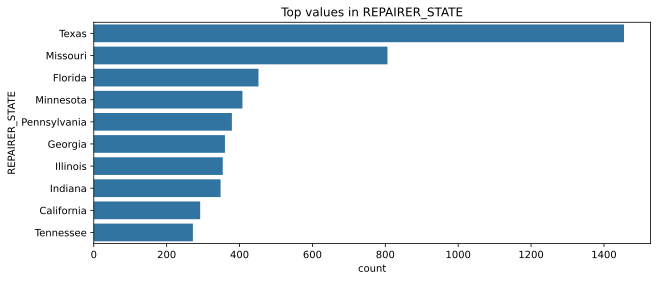

In [356]:
#Counterplots for top categorical features
for col in ['ITEM_NAME', 'VEHICLE_MODEL', 'REPAIRER_STATE']:
    plt.figure(figsize=(10,4))
    sns.countplot(y=col, data=df, order=df[col].value_counts().index[:10])
    plt.title(f"Top values in {col}")
    plt.show()

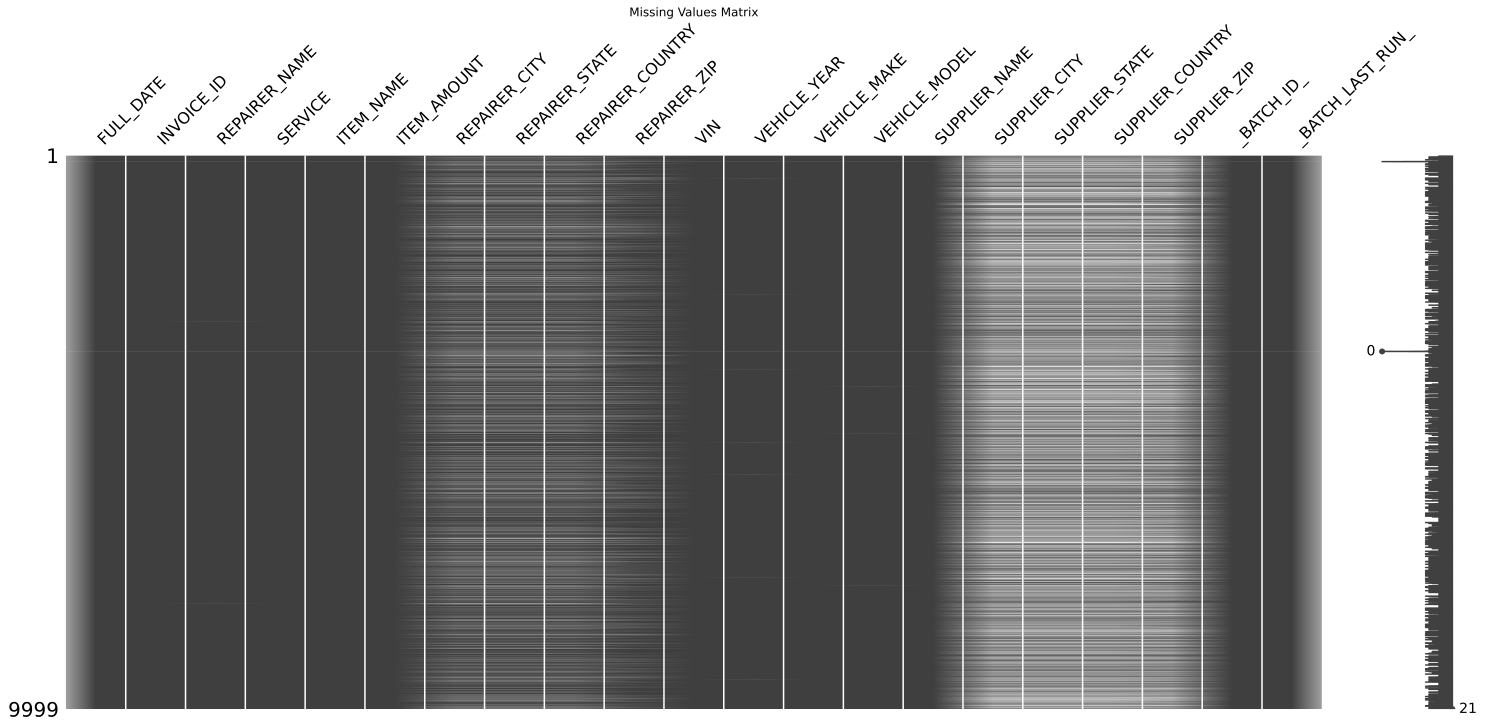

Missing Value %:
 FULL_DATE            0.020002
INVOICE_ID           0.020002
REPAIRER_NAME        0.040004
SERVICE              0.020002
ITEM_NAME            0.020002
ITEM_AMOUNT          0.020002
REPAIRER_CITY       14.931493
REPAIRER_STATE      14.931493
REPAIRER_COUNTRY    14.931493
REPAIRER_ZIP         6.290629
VIN                  0.020002
VEHICLE_YEAR         0.100010
VEHICLE_MAKE         0.020002
VEHICLE_MODEL        0.050005
SUPPLIER_NAME        0.020002
SUPPLIER_CITY       44.684468
SUPPLIER_STATE      44.684468
SUPPLIER_COUNTRY    44.684468
SUPPLIER_ZIP        41.404140
_BATCH_ID_           0.020002
_BATCH_LAST_RUN_     0.020002
dtype: float64


In [357]:
#Missing Value Heatmap
msno.matrix(df)
plt.title("Missing Values Matrix")
plt.show()

missing_percent = df.isnull().mean() * 100
print("Missing Value %:\n", missing_percent[missing_percent > 0])

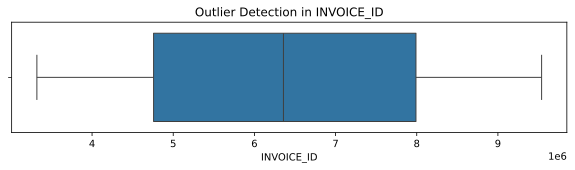

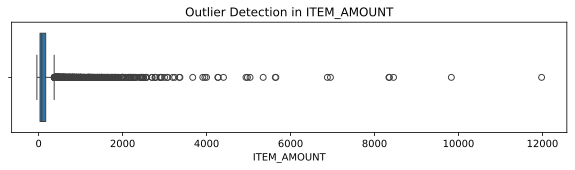

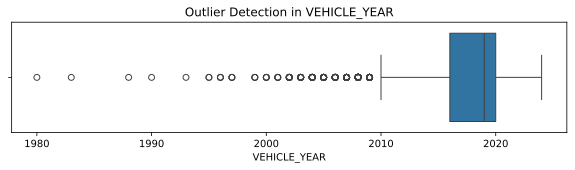

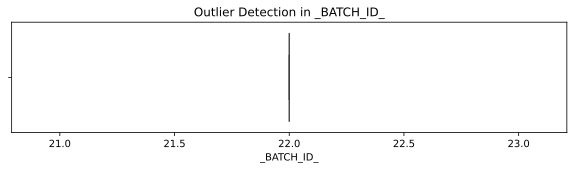

In [358]:
for col in numeric_cols:
    plt.figure(figsize=(10,2))
    sns.boxplot(x=df[col])
    plt.title(f"Outlier Detection in {col}")
    plt.show()

In [359]:
#Handle Missing values

#Item mapping

# List of accepted categories
clean_categories = [
    "HAIL",
    "PDR",
    "GLASS",
    "PACKAGE",
    "PPF VINYL PACKAGE",
    "PARTS",
    "WHEEL",
    "TINT",
    "MISC",
    "DETAIL",
    "PPF VINYL",
    "REMOVEINSTALL",
    "PRICE A DENT",
    "PAINT & BODY",
    "DETAIL PACKAGE",
    "PPF VINYL MATERIAL"
]

def fuzzy_clean_item_name(raw_name):
    try:
        name = str(raw_name).upper().strip()
        best_match, score, _ = process.extractOne(name, clean_categories)
        return best_match if score > 80 else name
    except Exception as e:
        print(f"Skipping value: {raw_name} due to error: {e}")
        return raw_name  # fallback if something goes wrong

df['SERVICE'] = df['SERVICE'].apply(fuzzy_clean_item_name).str.upper().str.strip()



# Make a copy to preserve original
df_cleaned = df.copy()

# Strategy examples:
for col in numeric_cols:
    df_cleaned[col].fillna(df_cleaned[col].mean(), inplace=True)

for col in categorical_cols:
    df_cleaned[col].fillna(df_cleaned[col].mode()[0], inplace=True)

<ipython-input-359-0c8499dadb27>:43: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_cleaned[col].fillna(df_cleaned[col].mean(), inplace=True)
<ipython-input-359-0c8499dadb27>:46: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=

In [360]:
#Handle Imbalanced Dataset
#sns.countplot(data=df_cleaned, y='ITEM_NAME', order=df_cleaned['ITEM_NAME'].value_counts().index)
#plt.title("Class Distribution: ITEM_NAME")

In [361]:
print("Numerical Features:\n", numeric_cols)
print("\nCategorical Features:\n", categorical_cols)

Numerical Features:
 Index(['INVOICE_ID', 'ITEM_AMOUNT', 'VEHICLE_YEAR', '_BATCH_ID_'], dtype='object')

Categorical Features:
 Index(['FULL_DATE', 'REPAIRER_NAME', 'SERVICE', 'ITEM_NAME', 'REPAIRER_CITY',
       'REPAIRER_STATE', 'REPAIRER_COUNTRY', 'REPAIRER_ZIP', 'VIN',
       'VEHICLE_MAKE', 'VEHICLE_MODEL', 'SUPPLIER_NAME', 'SUPPLIER_CITY',
       'SUPPLIER_STATE', 'SUPPLIER_COUNTRY', 'SUPPLIER_ZIP',
       '_BATCH_LAST_RUN_'],
      dtype='object')


In [362]:
# Test Outliers with IQR method
Q1 = df_cleaned[numeric_cols].quantile(0.25)
Q3 = df_cleaned[numeric_cols].quantile(0.75)
IQR = Q3 - Q1

df_no_outliers = df_cleaned[~((df_cleaned[numeric_cols] < (Q1 - 1.5 * IQR)) |
                              (df_cleaned[numeric_cols] > (Q3 + 1.5 * IQR))).any(axis=1)]
print("Original size:", df_cleaned.shape)
print("No outlier size:", df_no_outliers.shape)

Original size: (9999, 21)
No outlier size: (8805, 21)


In [363]:
print("Numerical Features:\n", numeric_cols)
print("\nCategorical Features:\n", categorical_cols)

Numerical Features:
 Index(['INVOICE_ID', 'ITEM_AMOUNT', 'VEHICLE_YEAR', '_BATCH_ID_'], dtype='object')

Categorical Features:
 Index(['FULL_DATE', 'REPAIRER_NAME', 'SERVICE', 'ITEM_NAME', 'REPAIRER_CITY',
       'REPAIRER_STATE', 'REPAIRER_COUNTRY', 'REPAIRER_ZIP', 'VIN',
       'VEHICLE_MAKE', 'VEHICLE_MODEL', 'SUPPLIER_NAME', 'SUPPLIER_CITY',
       'SUPPLIER_STATE', 'SUPPLIER_COUNTRY', 'SUPPLIER_ZIP',
       '_BATCH_LAST_RUN_'],
      dtype='object')


In [364]:
# Scaling the Data

from sklearn.preprocessing import StandardScaler, MinMaxScaler

scaler = StandardScaler()
df_scaled = df_no_outliers.copy()
df_scaled[numeric_cols] = scaler.fit_transform(df_scaled[numeric_cols])

#MinMaxScaler
df_scaled[numeric_cols] = MinMaxScaler().fit_transform(df_scaled[numeric_cols])


essential_cols = ['ITEM_NAME', 'VEHICLE_MODEL', 'REPAIRER_STATE']
# Check number of unique values in each categorical column
high_card_cols = [col for col in categorical_cols
                  if df_scaled[col].nunique() > 100 and col not in essential_cols]
print("High-cardinality columns:", high_card_cols)

# Drop high cordinality columns
df_scaled.drop(columns=high_card_cols, inplace=True)
# Drop or exclude them from encoding
safe_cat_cols = [col for col in categorical_cols if col not in high_card_cols]


High-cardinality columns: ['FULL_DATE', 'REPAIRER_NAME', 'REPAIRER_CITY', 'REPAIRER_ZIP', 'VIN', 'SUPPLIER_NAME', 'SUPPLIER_CITY', 'SUPPLIER_ZIP']


In [365]:
print("Numerical Features:\n", numeric_cols)
print("\nCategorical Features:\n", categorical_cols)

Numerical Features:
 Index(['INVOICE_ID', 'ITEM_AMOUNT', 'VEHICLE_YEAR', '_BATCH_ID_'], dtype='object')

Categorical Features:
 Index(['FULL_DATE', 'REPAIRER_NAME', 'SERVICE', 'ITEM_NAME', 'REPAIRER_CITY',
       'REPAIRER_STATE', 'REPAIRER_COUNTRY', 'REPAIRER_ZIP', 'VIN',
       'VEHICLE_MAKE', 'VEHICLE_MODEL', 'SUPPLIER_NAME', 'SUPPLIER_CITY',
       'SUPPLIER_STATE', 'SUPPLIER_COUNTRY', 'SUPPLIER_ZIP',
       '_BATCH_LAST_RUN_'],
      dtype='object')


In [366]:
#Convert Categorical to Numeric

df_encoded = pd.get_dummies(df_scaled, columns=safe_cat_cols, drop_first=True)
df_encoded.head()


,INVOICE_ID,ITEM_AMOUNT,VEHICLE_YEAR,_BATCH_ID_,SERVICE_GLASS,SERVICE_HAIL,SERVICE_NAN,SERVICE_PACKAGE,SERVICE_PAINTANDBODY,SERVICE_PDR,...,SUPPLIER_STATE_Tennessee,SUPPLIER_STATE_Texas,SUPPLIER_STATE_Utah,SUPPLIER_STATE_Vermont,SUPPLIER_STATE_Virginia,SUPPLIER_STATE_Washington,SUPPLIER_STATE_West Virginia,SUPPLIER_STATE_Wisconsin,SUPPLIER_STATE_Wyoming,SUPPLIER_COUNTRY_United States
0,0.009095,0.297821,0.357143,0.0,False,True,False,False,False,False,...,False,False,False,False,False,False,False,False,False,True
4,0.123947,0.222760,0.642857,0.0,False,False,False,False,False,False,...,False,True,False,False,False,False,False,False,False,True
5,0.586974,0.343826,0.785714,0.0,False,False,False,False,False,True,...,False,False,False,False,False,False,False,False,False,True
6,0.368727,0.307506,0.714286,0.0,False,False,False,False,False,True,...,False,False,False,False,False,False,False,False,False,True
8,0.955805,0.283293,0.785714,0.0,False,False,False,False,False,True,...,False,False,False,False,False,False,False,False,False,True


In [367]:
print("Numerical Features:\n", numeric_cols)
print("\nCategorical Features:\n", categorical_cols)

Numerical Features:
 Index(['INVOICE_ID', 'ITEM_AMOUNT', 'VEHICLE_YEAR', '_BATCH_ID_'], dtype='object')

Categorical Features:
 Index(['FULL_DATE', 'REPAIRER_NAME', 'SERVICE', 'ITEM_NAME', 'REPAIRER_CITY',
       'REPAIRER_STATE', 'REPAIRER_COUNTRY', 'REPAIRER_ZIP', 'VIN',
       'VEHICLE_MAKE', 'VEHICLE_MODEL', 'SUPPLIER_NAME', 'SUPPLIER_CITY',
       'SUPPLIER_STATE', 'SUPPLIER_COUNTRY', 'SUPPLIER_ZIP',
       '_BATCH_LAST_RUN_'],
      dtype='object')


In [368]:
df_encoded

,INVOICE_ID,ITEM_AMOUNT,VEHICLE_YEAR,_BATCH_ID_,SERVICE_GLASS,SERVICE_HAIL,SERVICE_NAN,SERVICE_PACKAGE,SERVICE_PAINTANDBODY,SERVICE_PDR,...,SUPPLIER_STATE_Tennessee,SUPPLIER_STATE_Texas,SUPPLIER_STATE_Utah,SUPPLIER_STATE_Vermont,SUPPLIER_STATE_Virginia,SUPPLIER_STATE_Washington,SUPPLIER_STATE_West Virginia,SUPPLIER_STATE_Wisconsin,SUPPLIER_STATE_Wyoming,SUPPLIER_COUNTRY_United States
0,0.009095,0.297821,0.357143,0.0,False,True,False,False,False,False,...,False,False,False,False,False,False,False,False,False,True
4,0.123947,0.222760,0.642857,0.0,False,False,False,False,False,False,...,False,True,False,False,False,False,False,False,False,True
5,0.586974,0.343826,0.785714,0.0,False,False,False,False,False,True,...,False,False,False,False,False,False,False,False,False,True
6,0.368727,0.307506,0.714286,0.0,False,False,False,False,False,True,...,False,False,False,False,False,False,False,False,False,True
8,0.955805,0.283293,0.785714,0.0,False,False,False,False,False,True,...,False,False,False,False,False,False,False,False,False,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9993,0.337985,0.150121,0.785714,0.0,False,False,False,False,False,False,...,False,True,False,False,False,False,False,False,False,True
9995,0.827603,0.101695,0.571429,0.0,False,False,False,False,True,False,...,False,False,False,False,False,False,False,False,False,True
9996,0.513841,0.198547,0.214286,0.0,False,False,False,False,False,False,...,False,True,False,False,False,False,False,False,False,True
9997,0.729189,0.246973,0.785714,0.0,False,False,False,False,False,True,...,False,True,False,False,False,False,False,False,False,True


In [369]:
df_encoded.to_csv("cleaned_vehicle_data.csv", index=False)

In [370]:

file_path ="/content/cleaned_vehicle_data.csv"
df = pd.read_csv(file_path)

print(df.head())

   INVOICE_ID  ITEM_AMOUNT  VEHICLE_YEAR  _BATCH_ID_  SERVICE_GLASS  \
0    0.009095     0.297821      0.357143         0.0          False   
1    0.123947     0.222760      0.642857         0.0          False   
2    0.586974     0.343826      0.785714         0.0          False   
3    0.368727     0.307506      0.714286         0.0          False   
4    0.955805     0.283293      0.785714         0.0          False   

   SERVICE_HAIL  SERVICE_NAN  SERVICE_PACKAGE  SERVICE_PAINTANDBODY  \
0          True        False            False                 False   
1         False        False            False                 False   
2         False        False            False                 False   
3         False        False            False                 False   
4         False        False            False                 False   

   SERVICE_PDR  ...  SUPPLIER_STATE_Tennessee  SUPPLIER_STATE_Texas  \
0        False  ...                     False                 False   
1   

In [371]:
df.columns

Index(['INVOICE_ID', 'ITEM_AMOUNT', 'VEHICLE_YEAR', '_BATCH_ID_',
       'SERVICE_GLASS', 'SERVICE_HAIL', 'SERVICE_NAN', 'SERVICE_PACKAGE',
       'SERVICE_PAINTANDBODY', 'SERVICE_PDR',
       ...
       'SUPPLIER_STATE_Tennessee', 'SUPPLIER_STATE_Texas',
       'SUPPLIER_STATE_Utah', 'SUPPLIER_STATE_Vermont',
       'SUPPLIER_STATE_Virginia', 'SUPPLIER_STATE_Washington',
       'SUPPLIER_STATE_West Virginia', 'SUPPLIER_STATE_Wisconsin',
       'SUPPLIER_STATE_Wyoming', 'SUPPLIER_COUNTRY_United States'],
      dtype='object', length=1061)

Data shape: (8805, 1061)
Epoch 1/100, Train Loss: 0.0837, Test Loss: 0.0251
Epoch 2/100, Train Loss: 0.0263, Test Loss: 0.0218
Epoch 3/100, Train Loss: 0.0224, Test Loss: 0.0216
Epoch 4/100, Train Loss: 0.0217, Test Loss: 0.0214
Epoch 5/100, Train Loss: 0.0201, Test Loss: 0.0213
Epoch 6/100, Train Loss: 0.0193, Test Loss: 0.0214
Epoch 7/100, Train Loss: 0.0177, Test Loss: 0.0214
Epoch 8/100, Train Loss: 0.0169, Test Loss: 0.0216
Epoch 9/100, Train Loss: 0.0162, Test Loss: 0.0214
Epoch 10/100, Train Loss: 0.0156, Test Loss: 0.0213
Epoch 11/100, Train Loss: 0.0141, Test Loss: 0.0217
Epoch 12/100, Train Loss: 0.0135, Test Loss: 0.0219
Epoch 13/100, Train Loss: 0.0134, Test Loss: 0.0220
Epoch 14/100, Train Loss: 0.0129, Test Loss: 0.0225
Epoch 15/100, Train Loss: 0.0118, Test Loss: 0.0224
Epoch 16/100, Train Loss: 0.0115, Test Loss: 0.0223
Epoch 17/100, Train Loss: 0.0108, Test Loss: 0.0231
Epoch 18/100, Train Loss: 0.0109, Test Loss: 0.0234
Epoch 19/100, Train Loss: 0.0104, Test Loss: 0.0

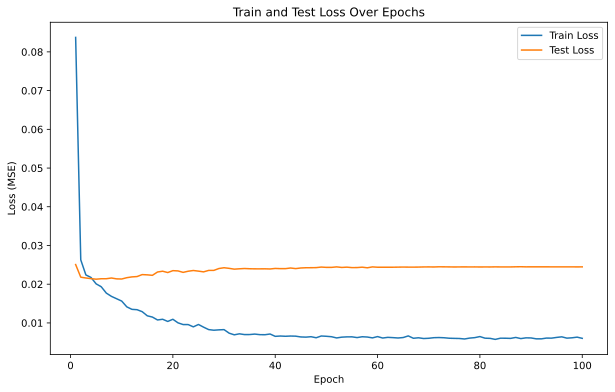


 Trained model saved as 'trained_repair_model.pt'


In [372]:
# COLAB-READY CLEANED VEHICLE DATA EDA + NEURAL NETWORK TRAINING PIPELINE

# 1. Load Cleaned Data
import pandas as pd
import numpy as np
import torch
from torch.utils.data import TensorDataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
from torch.optim.lr_scheduler import StepLR

# Upload your cleaned CSV file to Colab first (using left-side file explorer or `files.upload()`)
file_path = "/content/cleaned_vehicle_data.csv"
df = pd.read_csv(file_path)
print("Data shape:", df.shape)
df.head()

# 2. Feature / Target Split
X = df.drop(columns=['ITEM_AMOUNT'])
y = df['ITEM_AMOUNT']

# 3. Convert to PyTorch Tensors
X_tensor = torch.tensor(X.values.astype('float32'))
y_tensor = torch.tensor(y.values.astype('float32')).unsqueeze(1)

X_train, X_test, y_train, y_test = train_test_split(X_tensor, y_tensor, test_size=0.2, random_state=42)

train_dataset = TensorDataset(X_train, y_train)
test_dataset = TensorDataset(X_test, y_test)

batch_size = 64
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=len(test_dataset))

# 4. Define Neural Network
# 1. Added Dropout Layers (Regularization)
#    - Prevent overfitting by randomly dropping neurons during training.
class theNet(nn.Module):
    def __init__(self, input_size):
        super(theNet, self).__init__()
        self.fc1 = nn.Linear(input_size, 64)
        self.drop1 = nn.Dropout(0.2)
        self.fc2 = nn.Linear(64, 32)
        self.drop2 = nn.Dropout(0.2)
        self.fc3 = nn.Linear(32, 16)
        self.out = nn.Linear(16, 1)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = self.drop1(x)
        x = F.relu(self.fc2(x))
        x = self.drop2(x)
        x = F.relu(self.fc3(x))
        return self.out(x)

input_size = X.shape[1]
net = theNet(input_size)

# 5. Training Loop
optimizer = torch.optim.Adam(net.parameters(), lr=0.001)
scheduler = StepLR(optimizer, step_size=30, gamma=0.1)
lossfun = nn.MSELoss()

numepochs = 100
trainLoss = torch.zeros(numepochs)
testLoss = torch.zeros(numepochs)




for epochi in range(numepochs):
    net.train()
    batchLoss = []
    for X_batch, y_batch in train_loader:
        yHat = net(X_batch)
        loss = lossfun(yHat, y_batch)

        optimizer.zero_grad()
        loss.backward()
        #Gradient Clipping for stability
        torch.nn.utils.clip_grad_norm_(net.parameters(), max_norm=1.0)
        optimizer.step()

        batchLoss.append(loss.item())

    trainLoss[epochi] = np.mean(batchLoss)

    # Step the learning rate scheduler
    scheduler.step()
    # Test phase
    net.eval()
    X_val, y_val = next(iter(test_loader))
    with torch.no_grad():
        yHat_val = net(X_val)
        testLoss[epochi] = lossfun(yHat_val, y_val).item()

    print(f"Epoch {epochi+1}/{numepochs}, Train Loss: {trainLoss[epochi]:.4f}, Test Loss: {testLoss[epochi]:.4f}")

print("\nTraining complete!")

# 6. Evaluate Model
net.eval()
with torch.no_grad():
    X_val, y_val = next(iter(test_loader))
    y_pred = net(X_val)

# Convert to numpy for evaluation
y_pred_np = y_pred.numpy()
y_test_np = y_val.numpy()

mse = mean_squared_error(y_test_np, y_pred_np)
mae = mean_absolute_error(y_test_np, y_pred_np)
r2 = r2_score(y_test_np, y_pred_np)

print("\n Model Performance:")
print(f"🔹 Mean Squared Error (MSE): {mse:.4f}")
print(f"🔹 Mean Absolute Error (MAE): {mae:.4f}")
print(f"🔹 R² Score: {r2:.4f}")

# 7. Plot Loss Curve
epochs = np.arange(1, numepochs+1)
plt.figure(figsize=(10,6))
plt.plot(epochs, trainLoss.numpy(), label='Train Loss')
plt.plot(epochs, testLoss.numpy(), label='Test Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss (MSE)')
plt.title('Train and Test Loss Over Epochs')
plt.legend()
plt.show()

# 8. Save Model
torch.save(net.state_dict(), "trained_repair_model.pt")
print("\n Trained model saved as 'trained_repair_model.pt'")


In [374]:

vehicle_model = "F150"
vehicle_year = 2017
item_name = "ROOF"
repairer_state = "California"

input_data = pd.DataFrame([[vehicle_year, item_name, vehicle_model, repairer_state]], columns=['VEHICLE_YEAR', 'ITEM_NAME', 'VEHICLE_MODEL', 'REPAIRER_STATE'])
input_data_encoded = pd.get_dummies(input_data)
input_data_encoded = input_data_encoded.reindex(columns=X.columns, fill_value=0)  # Eğitim veri setine uyum sağla
input_data_tensor = torch.tensor(input_data_encoded.values.astype('float32'))
model = theNet(input_size)
model.load_state_dict(torch.load("trained_repair_model.pt"))  # Eğitilmiş model dosyasını yükle
model.eval()  # Modeli değerlendirme moduna al
with torch.no_grad():
    prediction = model(input_data_tensor).item()

print(f"Tahmini Masraf: ${prediction:.2f}")


Tahmini Masraf: $445.92
